# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 138 kB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 44.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 34.8 MB/s eta 0:00:01


In [86]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [88]:
# Define transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081))])
to_tensor = transforms.Compose([transforms.ToTensor()])

# Create training set and define training dataloader
train_dataset_to_visualize = datasets.MNIST(root = 'data', train = True, download = True, transform = to_tensor)
train_dataloader_to_visualize = DataLoader(train_dataset_to_visualize, shuffle = True, batch_size=32)
train_dataset = datasets.MNIST(root = 'data', train = True, download = True, transform= transform)
train_dataloader = DataLoader(train_dataset, shuffle = True, batch_size=64)

# Create test set and define test dataloader
test_dataset = torchvision.datasets.MNIST(root = 'mnist', train = False, download = True, transform= transform)
test_dataloader = DataLoader(test_dataset, shuffle = True, batch_size = 64)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

First to tensor because al the tools work with tensor data types.
Then normalize because we want the values to be in a common scale. 

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [89]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

traindata set size 60000
test data set size 10000
tensor size torch.Size([1, 28, 28])
6


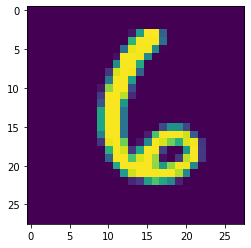

2


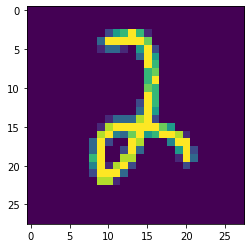

8


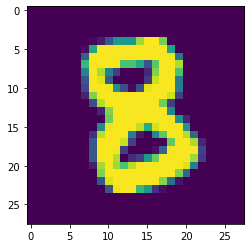

5


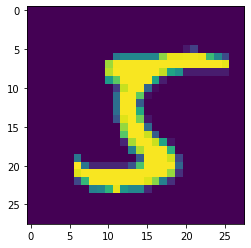

0


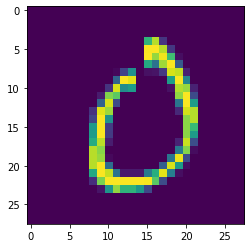

0


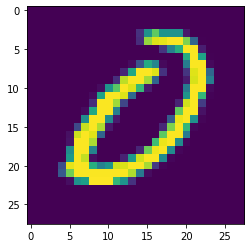

6


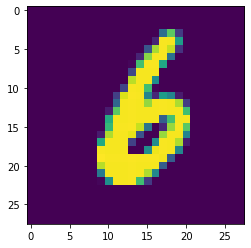

7


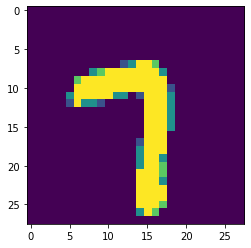

8


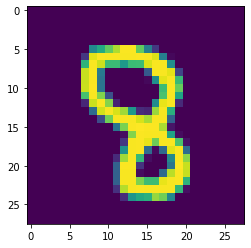

0


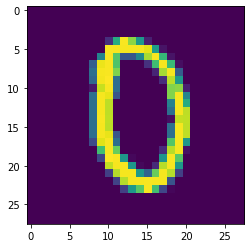

In [90]:
# Explore data
print(f'traindata set size {len(train_dataset)}')
print(f'test data set size {len(test_dataset)}')
dataloader_iter = iter(train_dataloader)
batch = next(dataloader_iter)
image = batch[0][0:5][0]
# print(f'tensor {image}')
print(f'tensor size {image.size()}')
show5(train_dataloader_to_visualize)
show5(train_dataloader)





## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [91]:
class MnistNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(1 * 28 * 28, 400)
        self.fc2 = nn.Linear(400, 10)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        nn.Dropout(p=0.2)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return x 

net = MnistNeuralNet()
net.to(device)

MnistNeuralNet(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [94]:
optimizer = optim.Adam(net.parameters(), lr = .00001, weight_decay = 0.1, betas = (0.9, 0.999))
loss_function = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [95]:
epochs = 10  
    
train_loss_history = list()
test_loss_history = list()

for epoch in range(epochs):
    net.train()
    accumulated_loss = 0.0
    accumulated_correct = 0
    for batch_idx, entry in enumerate(train_dataloader):
        img_tensor, labels = entry
        img_tensor, labels = img_tensor.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(img_tensor)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        accumulated_correct += (predicted == labels).sum().item()
        accumulated_loss += loss.item()
    print(f'epoch train {epoch} accurracy : {100*accumulated_correct/len(train_dataloader.dataset):.2f}% loss {accumulated_loss/len(train_dataloader.dataset):.5f}')
    train_loss_history.append(accumulated_loss/len(train_dataloader.dataset))
    
    accumulated_loss = 0.0
    accumulated_correct = 0
    net.eval()
    for tensors, labels in test_dataloader:
        tensors, labels = tensors.to(device), labels.to(device)
        
        outputs = net(tensors)
        loss = loss_function(outputs, labels)        
        _, predicted = torch.max(outputs.data, 1)
        accumulated_correct += (predicted == labels).sum().item() ##match max index with labels
        accumulated_loss += loss.item()
    print(f'epoch validation {epoch} {accumulated_correct} {len(test_dataloader.dataset)} accurracy : {100*accumulated_correct/len(test_dataloader.dataset):.2f}% loss {accumulated_loss/len(test_dataloader):.5f}')
    test_loss_history.append(accumulated_loss/len(test_dataloader.dataset))
    

epoch train 0 accurracy : 89.95% loss 0.00709
epoch validation 0 9051 10000 accurracy : 90.51% loss 0.43213
epoch train 1 accurracy : 90.19% loss 0.00702
epoch validation 1 9066 10000 accurracy : 90.66% loss 0.43034
epoch train 2 accurracy : 90.27% loss 0.00701
epoch validation 2 9064 10000 accurracy : 90.64% loss 0.43013
epoch train 3 accurracy : 90.28% loss 0.00701
epoch validation 3 9065 10000 accurracy : 90.65% loss 0.43097
epoch train 4 accurracy : 90.26% loss 0.00701
epoch validation 4 9065 10000 accurracy : 90.65% loss 0.43073
epoch train 5 accurracy : 90.25% loss 0.00701
epoch validation 5 9063 10000 accurracy : 90.63% loss 0.43016
epoch train 6 accurracy : 90.22% loss 0.00701
epoch validation 6 9073 10000 accurracy : 90.73% loss 0.42998
epoch train 7 accurracy : 90.28% loss 0.00701
epoch validation 7 9063 10000 accurracy : 90.63% loss 0.42994
epoch train 8 accurracy : 90.29% loss 0.00701
epoch validation 8 9070 10000 accurracy : 90.70% loss 0.42905
epoch train 9 accurracy : 90

Plot the training loss (and validation loss/accuracy, if recorded).

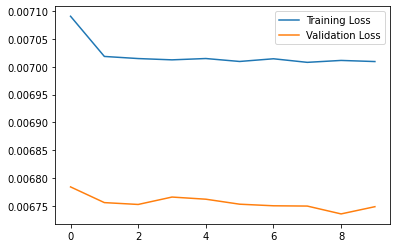

In [96]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(test_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [101]:
accumulated_loss = 0.0
accumulated_correct = 0
net.eval()
for tensors, labels in test_dataloader:
    tensors, labels = tensors.to(device), labels.to(device)
        
    outputs = net(tensors)
    loss = loss_function(outputs, labels)        
    _, predicted = torch.max(outputs.data, 1)
    accumulated_correct += (predicted == labels).sum().item() ##match max index with labels
    accumulated_loss += loss.item()
print(f'epoch validation {epoch} {accumulated_correct} {len(test_dataloader.dataset)} accurracy : {100*accumulated_correct/len(test_dataloader.dataset):.2f}% loss {accumulated_loss/len(test_dataloader):.5f}')


epoch validation 9 9078 10000 accurracy : 90.78% loss 0.42945


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [102]:
# upated the learning rate diminishing it improved
# added weight decay and betas to optimizer
# increased the batch size
# increased the number on nodes
# added another layer but it didn't improve

## Saving your model
Using `torch.save`, save your model for future loading.

In [103]:
torch.save

<function torch.serialization.save(obj, f: Union[str, os.PathLike, BinaryIO, IO[bytes]], pickle_module=<module 'pickle' from '/opt/conda/lib/python3.7/pickle.py'>, pickle_protocol=2, _use_new_zipfile_serialization=True) -> None>